In [1]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(NLP)
library(tm)
library(wordcloud)
library(ggplot2)
library(plotly)
library(tidytext)
library(tidyr)
library(lubridate)
library(MASS)
library(caret)



## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "../input")
ab <- read.csv("../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv")


## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   1.0.0          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The following object is masked from ‘package:httr’:

    content


Loading required package: RColorBrewer


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


The following object is masked from ‘package:httr’:

    config



Attaching package: ‘lubridate’


The following object is mask

[1] "new-york-city-airbnb-open-data"

In [2]:
#Declaring Categorical Variables using our response variable parameters

p = integer(10)
r = integer(10)


for (i in 1:10) {
     
     p[i] = quantile(ab$price,i * 0.1) 
     r[i] = quantile(ab$number_of_reviews,i * 0.1)
}

p
r

#Grouping our categorical variable by 20th Percentile Quantiles

ab <- ab %>% mutate(price_group=ifelse(price < 61, "Very Low",
                                           ifelse(price < 91, "Low",
                                                  ifelse(price < 131, "Moderate",
                                                         ifelse(price < 201, "High", "Very High"
                                                               )))))


ab <- ab %>% mutate(usage_group=ifelse(number_of_reviews < 1, "None",
                                         ifelse(number_of_reviews < 4, "Low",
                                                ifelse(number_of_reviews < 10, "Moderate",
                                                        ifelse(number_of_reviews < 34, "High", "Very High"
                                                        )))))

#Declaring our Response Variable

ab <- ab %>% mutate(total_net_revenue = price * number_of_reviews * minimum_nights)

#Displaying our new variables

head(ab[,17:19])



[1]    49    60    75    90   106   130   155   200   269 10000

[1]   0   0   1   3   5   9  17  33  70 629

,price_group,usage_group,total_net_revenue
,<chr>,<chr>,<int>
1,High,Moderate,1341
2,Very High,Very High,10125
3,High,None,0
4,Low,Very High,24030
5,Low,Moderate,7200
6,High,Very High,44400


In [3]:
#NLP Code

#Partitioning by Price Type

ab_vhp = subset(ab, price_group == "Very High")
ab_vlp = subset(ab, price_group == "Very Low")

length(ab_vhp$price_group)
length(ab_vlp$price_group)

#Storing into Corpus Format

dfa <- data.frame(doc_id = 1:48895, text = ab$name, stringsAsFactors = FALSE)
df_corpusa <- Corpus(DataframeSource(dfa))

dfh <- data.frame(doc_id = 1:8384, text = ab_vhp$name, stringsAsFactors = FALSE)
df_corpush <- Corpus(DataframeSource(dfh))

dfl <- data.frame(doc_id = 1:10063, text = ab_vlp$name, stringsAsFactors = FALSE)
df_corpusl <- Corpus(DataframeSource(dfl))

#Token Cleansing

df_corpush <- tm_map(df_corpush, removePunctuation)
df_corpusl <- tm_map(df_corpusl, removePunctuation)
df_corpusa <- tm_map(df_corpusa, removePunctuation)
df_corpush <- tm_map(df_corpush, tolower)
df_corpusl <- tm_map(df_corpusl, tolower)
df_corpusa <- tm_map(df_corpusa, tolower)
df_corpush <- tm_map(df_corpush, removeNumbers)
df_corpusl <- tm_map(df_corpusl, removeNumbers)
df_corpusa <- tm_map(df_corpusa, removeNumbers)
df_corpush <- tm_map(df_corpush, removeWords, stopwords("english"))
df_corpusl <- tm_map(df_corpusl, removeWords, stopwords("english"))
df_corpusa <- tm_map(df_corpusl, removeWords, stopwords("english"))


dtmh <-DocumentTermMatrix(df_corpush,control = list(weighting = function(x) weightTfIdf(x, normalize = FALSE)))
dtml <-DocumentTermMatrix(df_corpusl,control = list(weighting = function(x) weightTfIdf(x, normalize = FALSE)))
dtma <-DocumentTermMatrix(df_corpusa,control = list(weighting = function(x) weightTfIdf(x, normalize = FALSE)))

freqh <- sort(colSums(as.matrix(dtmh)), decreasing=TRUE)
freql <- sort(colSums(as.matrix(dtml)), decreasing=TRUE)
freqa <- sort(colSums(as.matrix(dtma)), decreasing=TRUE) 

wfh <- data.frame(word=names(freqh), freq=freqh) 
wfl <- data.frame(word=names(freql), freq=freql)
wf <- data.frame(word=names(freqa), freq=freqa)

set.seed(1)   

dark2 <- brewer.pal(6, "Dark2")



[1] 8384

[1] 10063

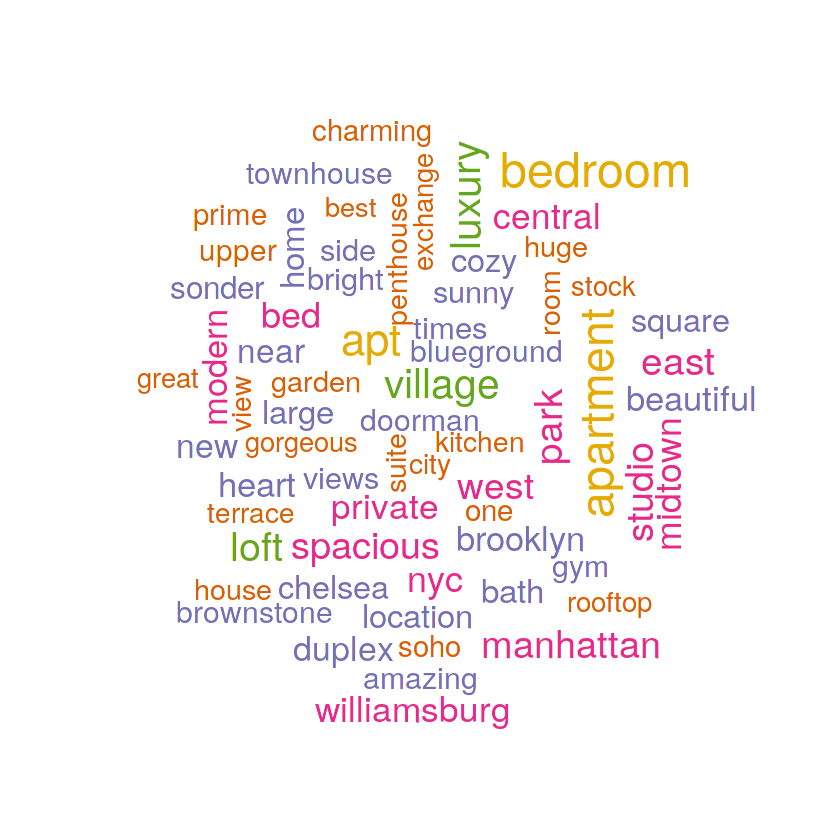

In [4]:
wordcloud(names(freqh), freqh, min.freq = 825, max.words=150, rot.per=0.2, colors=dark2,scale=c(2.4,1))



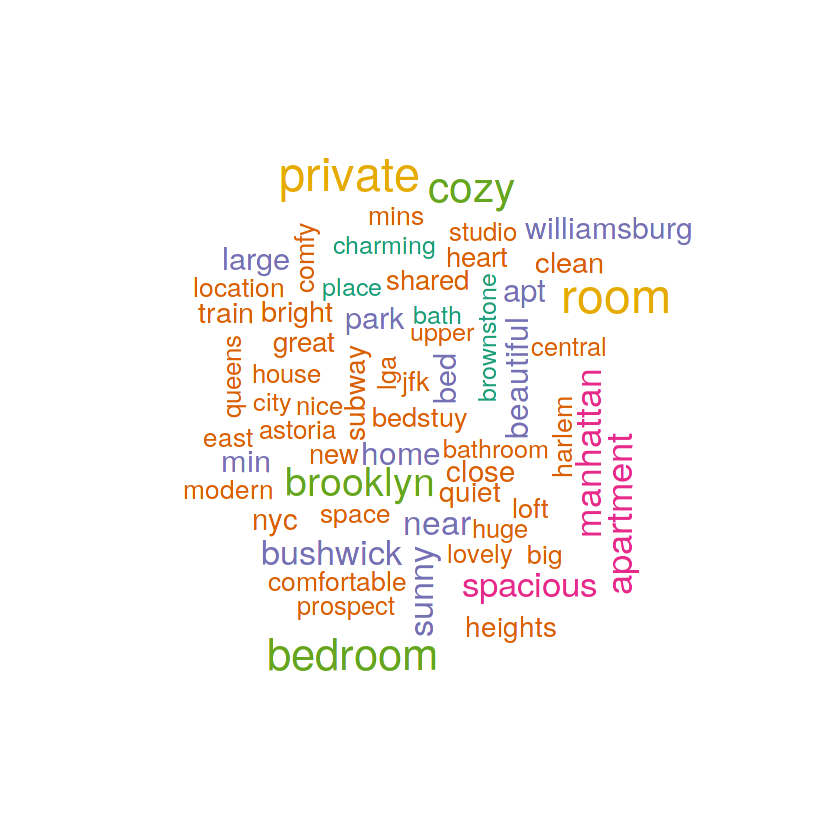

In [5]:
wordcloud(names(freql), freql, min.freq = 825, max.words=125, rot.per=0.2, colors=dark2,scale=c(2.4,1))